<a href="https://colab.research.google.com/github/learning-toolz/ml/blob/main/jhu_week_7_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                  feedback     label
0       I love this product, it's amazing!  positive
1       This is the worst experience ever.  negative
2  Absolutely fantastic! Highly recommend.  positive
3          Not good, really disappointing.  negative
4          I am extremely happy with this.  positive


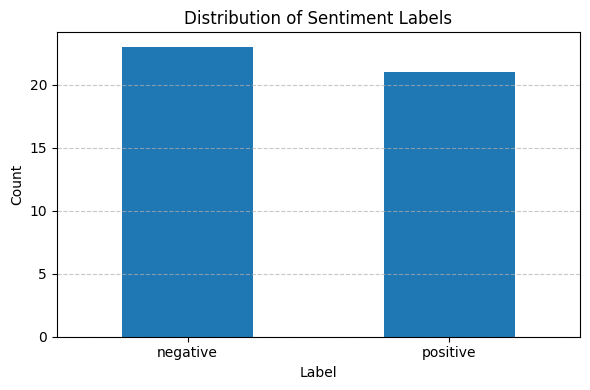

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



Sample preprocessed feedback:
                                  feedback  \
0       I love this product, it's amazing!   
1       This is the worst experience ever.   
2  Absolutely fantastic! Highly recommend.   
3          Not good, really disappointing.   
4          I am extremely happy with this.   

                        cleaned_feedback  
0                   love product amazing  
1                  worst experience ever  
2  absolutely fantastic highly recommend  
3              good really disappointing  
4                        extremely happy  

Classification Report for :  SVC(random_state=42)
              precision    recall  f1-score   support

    negative       0.67      0.40      0.50         5
    positive       0.50      0.75      0.60         4

    accuracy                           0.56         9
   macro avg       0.58      0.57      0.55         9
weighted avg       0.59      0.56      0.54         9

Accuracy: 0.5555555555555556

Classification Report for 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu



Transformer Sentiment Analysis Sample:
                        cleaned_feedback transformer_sentiment
0                   love product amazing              positive
1                  worst experience ever              negative
2  absolutely fantastic highly recommend              positive
3              good really disappointing              positive
4                        extremely happy              positive

Transformer Accuracy: 0.7954545454545454
Transformer Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.74      0.79        23
    positive       0.75      0.86      0.80        21

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44



In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Download required resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

def load_feedback_custom_format(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, start=1):
                try:
                    line = line.strip().rstrip(',')           # Remove trailing comma
                    line = line.strip('()')                   # Remove parentheses
                    reader = csv.reader([line], quotechar='"', delimiter=',', skipinitialspace=True)
                    for row in reader:
                        if len(row) == 2:
                            feedback, label = row
                            data.append((feedback, label))
                        else:
                            logging.warning(f"Line {line_num} skipped due to unexpected format: {line}")
                except Exception as e:
                    logging.error(f"Error parsing line {line_num}: {e}")

        df = pd.DataFrame(data, columns=['feedback', 'label'])
        logging.info(f"Loaded {len(df)} feedback entries.")
        print(df.head())
        return df
    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
    except Exception as e:
        logging.error(f"An error occurred while reading the file: {e}")
    return pd.DataFrame(columns=['feedback', 'label'])

def plot_label_distribution(df):
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(6, 4))
    label_counts.plot(kind='bar')
    plt.title('Distribution of Sentiment Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def preprocess_feedback(text):
    # Lowercasing: Converts all characters to lowercase to standardize text and reduce sparsity.
    text = text.lower()

    # Punctuation removal: Removes symbols like !, ?, . that may not carry sentiment.
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization: Splits text into words for easier processing.
    tokens = word_tokenize(text)

    # Stopword removal: Eliminates common words like "the", "is", etc., which do not add semantic value.
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming: Reduces words to their base/root form (e.g., running -> run).
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization: Converts words to dictionary form (e.g., better -> good), using context.
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

def train_and_evaluate_model(X, y, model=None):
    if model is None:
        model = LogisticRegression(class_weight='balanced', max_iter=1000)

    # Split the dataset first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit on training data only, transform both train and test
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    print("\nClassification Report for : ", model)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))


def analyze_sentiment_with_vader(df):
    sia = SentimentIntensityAnalyzer()
    def get_sentiment(text):
        score = sia.polarity_scores(text)['compound']
        return 'positive' if score >= 0 else 'negative'
    df['vader_sentiment'] = df['feedback'].apply(get_sentiment)
    print("\nVADER Sentiment Analysis Sample:")
    print(df[['feedback', 'vader_sentiment']].head())

    # Evaluate VADER sentiment predictions
    accuracy = accuracy_score(df['label'], df['vader_sentiment'])
    print("\nVADER Accuracy:", accuracy)
    print("VADER Classification Report:")
    print(classification_report(df['label'], df['vader_sentiment']))

def analyze_sentiment_with_transformer(df):
    transformer_pipeline = pipeline("sentiment-analysis")
    def get_transformer_sentiment(text):
        result = transformer_pipeline(text)[0]
        return 'positive' if result['label'].lower() == 'positive' else 'negative'
    df['transformer_sentiment'] = df['cleaned_feedback'].apply(get_transformer_sentiment)
    print("\nTransformer Sentiment Analysis Sample:")
    print(df[['cleaned_feedback', 'transformer_sentiment']].head())

    # Evaluate Transformer sentiment predictions
    accuracy = accuracy_score(df['label'], df['transformer_sentiment'])
    print("\nTransformer Accuracy:", accuracy)
    print("Transformer Classification Report:")
    print(classification_report(df['label'], df['transformer_sentiment']))

# main program
if __name__ == '__main__':
    # Load the file
    FILE_PATH = 'sample_data/jhu_week7_feedback.txt'
    df_feedback = load_feedback_custom_format(FILE_PATH)
    # Visualize the data
    plot_label_distribution(df_feedback)

    # Apply preprocessing to feedback text
    df_feedback['cleaned_feedback'] = df_feedback['feedback'].apply(preprocess_feedback)
    print("\nSample preprocessed feedback:")
    print(df_feedback[['feedback', 'cleaned_feedback']].head())

    # Train and evaluate model with default SVC
    train_and_evaluate_model(df_feedback['cleaned_feedback'], df_feedback['label'], model = SVC(kernel='rbf', random_state=42))
    train_and_evaluate_model(df_feedback['cleaned_feedback'], df_feedback['label'], model = RandomForestClassifier(n_estimators=10, random_state=42))

    # Using NLP (statistical)
    analyze_sentiment_with_vader(df_feedback)

    # Using NLP (transformer based)
    analyze_sentiment_with_transformer(df_feedback)


